In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=53d1790eb76f8deee2b9fa84aedeeca5d43a9febdfd3950d2a58081d1ff7fb36
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


# 1 - Download Walmart Data

In [ ]:
# Téléchargement des données à partir du repo git
!wget "https://github.com/ettouilebouael/pyspark_for_datascience/raw/refs/heads/main/data/walmart_data.zip"

# Création d'un dossier pour les données walmart
!mkdir walmart_data

# Décompression du fichier zip contenant les données
!unzip walmart_data.zip -d walmart_data

# lister les fichiers

!ls walmart_data

--2024-10-15 06:08:45--  https://github.com/ettouilebouael/pyspark_for_datascience/raw/refs/heads/main/data/walmart_data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ettouilebouael/pyspark_for_datascience/refs/heads/main/data/walmart_data.zip [following]
--2024-10-15 06:08:46--  https://media.githubusercontent.com/media/ettouilebouael/pyspark_for_datascience/refs/heads/main/data/walmart_data.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132754996 (127M) [application/zip]
Saving to: ‘walmart_data.zip’

walmart_data.zip    100%[===================>] 126.60M  63.1MB/s

In [ ]:
# Création d'un dossier pour les données walmart
!mkdir walmart_data

# Décompression du fichier zip contenant les données
!unzip walmart_data.zip -d walmart_data

# lister les fichiers

!ls walmart_data

Archive:  walmart_data.zip
  inflating: walmart_data/calendar.parquet  
  inflating: walmart_data/sell_prices.parquet  
  inflating: walmart_data/walmart_sales.parquet  
calendar.parquet  sell_prices.parquet  walmart_sales.parquet


In [ ]:
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from google.colab import drive
drive.mount('/content/drive')


OUTPUT_PATH = "/content/drive/MyDrive/monthly_sales_data"

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder.getOrCreate()

# Load Data

In [ ]:
df_prices = spark.read.parquet("walmart_data/sell_prices.parquet")

In [ ]:
df_prices.limit(5).toPandas()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
df_calendar =  spark.read.parquet("walmart_data/calendar.parquet")

In [ ]:
df_calendar.limit(5).toPandas()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [ ]:
df = spark.read.parquet("walmart_data/walmart_sales.parquet")

In [ ]:
df.columns

['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'id', 'date', 'sales']

In [ ]:
df1 = df.withColumn("date", F.to_date("date", "yyyy-MM-dd")).groupby("item_id", "store_id").agg(F.max("date").alias("date")).toPandas()

In [ ]:
df1.date.unique()

array([datetime.date(2016, 4, 24)], dtype=object)

# Vérification des données

## Nombre d'obervations

In [ ]:
df.count()

58327370

## Valeurs Manquantes

In [ ]:
df.select([F.sum(F.isnull(col).cast("int")).alias(col) for col in df.columns]).toPandas()

,item_id,dept_id,cat_id,store_id,state_id,id,date,sales
0,0,0,0,0,0,0,0,0


## Schema

In [ ]:
df.printSchema()

root
 |-- item_id: string (nullable = true)
 |-- dept_id: string (nullable = true)
 |-- cat_id: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- sales: long (nullable = true)



## 2 - Parsing des dates

In [ ]:
df_date_parsed = df.withColumn("date", F.to_date("date", "yyyy-MM-dd"))

In [ ]:
df_date_parsed.agg(F.min("date"), F.max("date")).toPandas()

,min(date),max(date)
0,2011-01-29,2016-04-24


## Sales Stats

In [ ]:
df_date_parsed.describe("sales").toPandas()

,summary,sales
0,count,58327370
1,mean,1.126322153733316
2,stddev,3.8731084464718286
3,min,0
4,max,763


## Visualisation des timeseries

In [ ]:
df_date_parsed.limit(5).toPandas()

,item_id,dept_id,cat_id,store_id,state_id,id,date,sales
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_001_CA_1_validation,2011-01-29,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_002_CA_1_validation,2011-01-29,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_003_CA_1_validation,2011-01-29,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_004_CA_1_validation,2011-01-29,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_005_CA_1_validation,2011-01-29,0


In [ ]:
df_date_parsed.filter((F.col("dept_id") == "FOODS_1") & (F.col("store_id") == "CA_1")).select("id").distinct().toPandas()

,id
0,FOODS_1_011_CA_1_validation
1,FOODS_1_096_CA_1_validation
2,FOODS_1_154_CA_1_validation
3,FOODS_1_044_CA_1_validation
4,FOODS_1_170_CA_1_validation
...,...
211,FOODS_1_195_CA_1_validation
212,FOODS_1_050_CA_1_validation
213,FOODS_1_130_CA_1_validation
214,FOODS_1_146_CA_1_validation


<Axes: xlabel='date'>

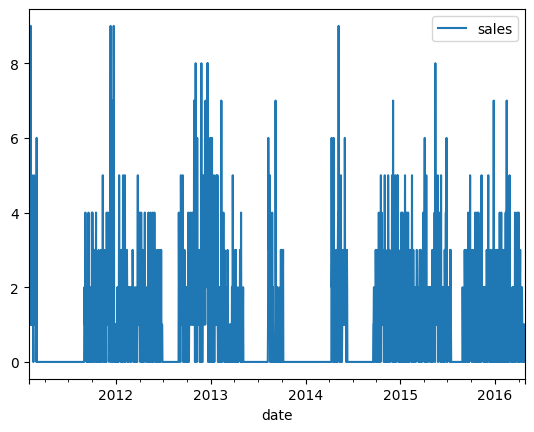

In [ ]:
(
    df_date_parsed
    .filter(F.col("id") == "FOODS_1_195_CA_1_validation")
    .toPandas()
    .assign(date=lambda x:pd.to_datetime(x.date, format="yyyy-MM-dd"))
    .sort_values("date")
    .set_index("date")
    .plot()
)


## Vérifier les doublons

In [ ]:
df_date_parsed.groupby("item_id", "store_id", "date").agg(F.count(F.lit(1)).alias("nb_obs")).agg(F.max("nb_obs")).collect()[0][0]

1

# Construction de la table de travail

## Agrégation des données de ventes à la maille : (Mois x produits x Magasins)

In [ ]:
df_agg_monthly_sales = (
    df_date_parsed
    .filter(F.col("sales") >= 0)
    .withColumn("date", F.trunc("date", "month"))
    .groupby(
        "date", 'item_id', 'dept_id',
        'cat_id', 'store_id', 'state_id', 'id'
      )
    .agg(
        F.sum("sales").alias("sales"),
    )
)

## Ajouter les mois sans transactions et les imputer avec 0

In [ ]:
max_date = df_agg_monthly_sales.agg(F.max("date")).collect()[0][0]

In [ ]:
df_core = (
    df_agg_monthly_sales
    .groupby(
        "item_id","store_id"
    )
    .agg(
        F.min("date").alias("start_date"),
    )
    .withColumn("end_date", F.lit(max_date).cast("date"))
    .withColumn("dates_list", F.sequence(
        start=F.col("start_date"),
        stop=F.col("end_date"),
        step=F.make_interval(months=F.lit(1)))
    )
    .select(
        "item_id",
        "store_id",
        F.explode("dates_list").alias("date")
    )
)

In [ ]:
df_output = (
    df_core
    .join(
        df_agg_monthly_sales,
        on=["item_id", "store_id", "date"],
        how="left"
    )
    .fillna(value=0, subset="sales")
)

In [ ]:
df_output.count(), df_core.count(), df_agg_monthly_sales.count()

(1951360, 1951360, 1951360)

On a toutes les lignes pas besoin d'imputation

# Sauvegarder la table de travail

In [ ]:
df_output.limit(5).toPandas()

,item_id,store_id,date,dept_id,cat_id,state_id,id,sales
0,HOBBIES_1_044,CA_1,2011-04-01,HOBBIES_1,HOBBIES,CA,HOBBIES_1_044_CA_1_validation,43
1,HOBBIES_1_044,CA_1,2011-05-01,HOBBIES_1,HOBBIES,CA,HOBBIES_1_044_CA_1_validation,43
2,HOBBIES_1_044,CA_1,2011-01-01,HOBBIES_1,HOBBIES,CA,HOBBIES_1_044_CA_1_validation,8
3,HOBBIES_1_044,CA_1,2011-02-01,HOBBIES_1,HOBBIES,CA,HOBBIES_1_044_CA_1_validation,77
4,HOBBIES_1_044,CA_1,2011-03-01,HOBBIES_1,HOBBIES,CA,HOBBIES_1_044_CA_1_validation,47


In [ ]:
df_output.write.mode('overwrite').format('parquet').save(OUTPUT_PATH)